In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import gc
import time, pickle
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, fbeta_score, f1_score, precision_score, recall_score 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

from sklearn.feature_selection import RFECV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

from joblib import load, dump

import shap

import os

import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Chargement des données
application_train = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv")
application_test = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_test.csv")
bureau = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv")
credit_card_balance = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv")
installments_payments = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv")
POS_CASH_balance = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv")
previous_application = pd.read_csv("/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv")

In [3]:
application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [5]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [6]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows= num_rows, encoding='utf-8')
    test_df = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv', nrows= num_rows, encoding='utf-8')
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [7]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv', nrows = num_rows, encoding='utf-8')
    bb = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv', nrows = num_rows, encoding='utf-8')
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [8]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv', nrows = num_rows, encoding='utf-8')
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


In [9]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows, encoding='utf-8')
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [10]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [11]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv', nrows = num_rows, encoding='utf-8')
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [12]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
    return df

In [13]:
data = main()

Train samples: 307511, test samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 9s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 9s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 5s
Installments payments df shape: (339587, 26)
Process installments payments - done in 15s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 7s


In [14]:
data

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615018,307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615019,307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615020,307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
D = (data.isnull().sum().sort_values().head(798))/615014
D

index                                    0.000000
OCCUPATION_TYPE_Medicine staff           0.000000
OCCUPATION_TYPE_Private service staff    0.000000
OCCUPATION_TYPE_Realty agents            0.000000
OCCUPATION_TYPE_Sales staff              0.000000
                                           ...   
REFUSED_RATE_DOWN_PAYMENT_MEAN           0.853116
REFUSED_RATE_DOWN_PAYMENT_MAX            0.853116
REFUSED_RATE_DOWN_PAYMENT_MIN            0.853116
REFUSED_AMT_DOWN_PAYMENT_MIN             0.853116
REFUSED_AMT_DOWN_PAYMENT_MAX             0.853116
Length: 798, dtype: float64

la valeur 0 signifie que le prêt est remboursé la valeur 1 signifie que le prêt n'est pas remboursé

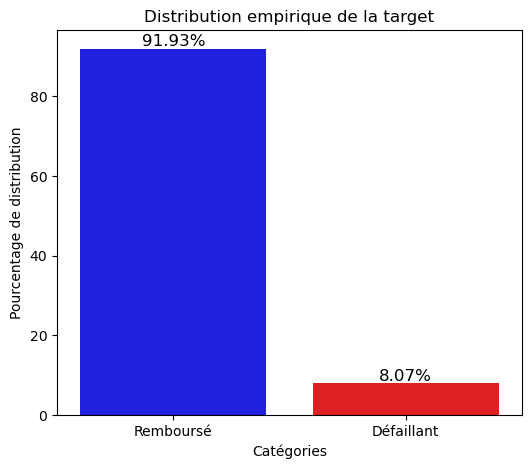

In [16]:

Imbalance = data
# Créez une figure et un axe
plt.figure(figsize=(6, 5))
ax = sns.barplot(x="TARGET", y="TARGET", data=Imbalance, palette=['b', 'r'], estimator=lambda x: len(x) / len(Imbalance) * 100)

# Personnalisez les étiquettes de l'axe des abscisses
ax.set_xticklabels(['Remboursé', 'Défaillant'])

# Ajoutez les pourcentages au-dessus des barres
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Personnalisez les étiquettes des axes, le titre, etc.
plt.ylabel('Pourcentage de distribution')
plt.xlabel('Catégories')
plt.title("Distribution empirique de la target")

# Affichez le graphique
plt.show()


In [17]:
data['TARGET'].isnull().sum()

0

In [18]:
# Filtrez les colonnes où le pourcentage de valeurs manquantes est inférieur à 5%
selected_columns = D[D < 0.05].index

# Créez un nouveau DataFrame avec seulement les colonnes sélectionnées
df = data[selected_columns]

In [19]:
df

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,0,0,0,0,0,0,0,0,0,0,...,202500.0,0.060749,0.121978,24700.5,351000.0,0.262949,2.0,2.0,2.0,2.0
1,1,0,0,0,0,0,0,0,0,1,...,135000.0,0.027598,0.132217,35698.5,1129500.0,0.622246,1.0,1.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,1,...,67500.0,0.050000,0.100000,6750.0,135000.0,0.555912,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,67500.0,0.094941,0.219900,29686.5,297000.0,0.650442,2.0,2.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,121500.0,0.042623,0.179963,21865.5,513000.0,0.322738,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,0,0,0,1,0,0,0,0,0,...,157500.0,0.108198,0.174971,27558.0,225000.0,0.681632,0.0,0.0,0.0,0.0
615018,307507,0,0,0,0,0,0,0,0,1,...,72000.0,0.044524,0.166687,12001.5,225000.0,0.115992,0.0,0.0,0.0,0.0
615019,307508,0,0,0,0,0,0,0,0,0,...,153000.0,0.044239,0.195941,29979.0,585000.0,0.535722,6.0,6.0,0.0,0.0
615020,307509,0,0,0,0,0,0,0,0,0,...,85500.0,0.054592,0.118158,20205.0,319500.0,0.514163,0.0,0.0,0.0,0.0


In [20]:
df.columns


Index(['index', 'OCCUPATION_TYPE_Medicine staff',
       'OCCUPATION_TYPE_Private service staff',
       'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff',
       'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff',
       'OCCUPATION_TYPE_Waiters/barmen staff',
       'WEEKDAY_APPR_PROCESS_START_FRIDAY',
       'WEEKDAY_APPR_PROCESS_START_MONDAY',
       ...
       'INCOME_PER_PERSON', 'PAYMENT_RATE', 'ANNUITY_INCOME_PERC',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object', length=194)

In [21]:
F = (df.isnull().sum().sort_values().head(194))/615014
F

index                                    0.000000
ORGANIZATION_TYPE_Security Ministries    0.000000
ORGANIZATION_TYPE_Self-employed          0.000000
ORGANIZATION_TYPE_Services               0.000000
ORGANIZATION_TYPE_Trade: type 1          0.000000
                                           ...   
EXT_SOURCE_2                             0.002146
OBS_60_CNT_SOCIAL_CIRCLE                 0.003320
OBS_30_CNT_SOCIAL_CIRCLE                 0.003320
DEF_30_CNT_SOCIAL_CIRCLE                 0.003320
DEF_60_CNT_SOCIAL_CIRCLE                 0.003320
Length: 194, dtype: float64

In [22]:
mean_per_column = df.mean()

# Remplacez les valeurs manquantes dans chaque colonne par la moyenne respective
df_filled = df.fillna(mean_per_column)

In [23]:
df_filled

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,0,0,0,0,0,0,0,0,0,0,...,202500.0,0.060749,0.121978,24700.5,351000.0,0.262949,2.0,2.0,2.0,2.0
1,1,0,0,0,0,0,0,0,0,1,...,135000.0,0.027598,0.132217,35698.5,1129500.0,0.622246,1.0,1.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,1,...,67500.0,0.050000,0.100000,6750.0,135000.0,0.555912,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,67500.0,0.094941,0.219900,29686.5,297000.0,0.650442,2.0,2.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,121500.0,0.042623,0.179963,21865.5,513000.0,0.322738,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,0,0,0,1,0,0,0,0,0,...,157500.0,0.108198,0.174971,27558.0,225000.0,0.681632,0.0,0.0,0.0,0.0
615018,307507,0,0,0,0,0,0,0,0,1,...,72000.0,0.044524,0.166687,12001.5,225000.0,0.115992,0.0,0.0,0.0,0.0
615019,307508,0,0,0,0,0,0,0,0,0,...,153000.0,0.044239,0.195941,29979.0,585000.0,0.535722,6.0,6.0,0.0,0.0
615020,307509,0,0,0,0,0,0,0,0,0,...,85500.0,0.054592,0.118158,20205.0,319500.0,0.514163,0.0,0.0,0.0,0.0


In [24]:
G = (df_filled.isnull().sum().sort_values().head(194))/615014
G

index                                    0.0
NAME_INCOME_TYPE_Commercial associate    0.0
FLAG_DOCUMENT_5                          0.0
FLAG_DOCUMENT_4                          0.0
FLAG_DOCUMENT_3                          0.0
                                        ... 
ORGANIZATION_TYPE_Transport: type 3      0.0
ORGANIZATION_TYPE_Transport: type 4      0.0
ORGANIZATION_TYPE_University             0.0
NAME_HOUSING_TYPE_Office apartment       0.0
DEF_60_CNT_SOCIAL_CIRCLE                 0.0
Length: 194, dtype: float64

In [25]:
df_filled

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,0,0,0,0,0,0,0,0,0,0,...,202500.0,0.060749,0.121978,24700.5,351000.0,0.262949,2.0,2.0,2.0,2.0
1,1,0,0,0,0,0,0,0,0,1,...,135000.0,0.027598,0.132217,35698.5,1129500.0,0.622246,1.0,1.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,1,...,67500.0,0.050000,0.100000,6750.0,135000.0,0.555912,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,67500.0,0.094941,0.219900,29686.5,297000.0,0.650442,2.0,2.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,121500.0,0.042623,0.179963,21865.5,513000.0,0.322738,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,0,0,0,1,0,0,0,0,0,...,157500.0,0.108198,0.174971,27558.0,225000.0,0.681632,0.0,0.0,0.0,0.0
615018,307507,0,0,0,0,0,0,0,0,1,...,72000.0,0.044524,0.166687,12001.5,225000.0,0.115992,0.0,0.0,0.0,0.0
615019,307508,0,0,0,0,0,0,0,0,0,...,153000.0,0.044239,0.195941,29979.0,585000.0,0.535722,6.0,6.0,0.0,0.0
615020,307509,0,0,0,0,0,0,0,0,0,...,85500.0,0.054592,0.118158,20205.0,319500.0,0.514163,0.0,0.0,0.0,0.0


In [26]:
df_filled.columns

Index(['index', 'OCCUPATION_TYPE_Medicine staff',
       'OCCUPATION_TYPE_Private service staff',
       'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff',
       'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security staff',
       'OCCUPATION_TYPE_Waiters/barmen staff',
       'WEEKDAY_APPR_PROCESS_START_FRIDAY',
       'WEEKDAY_APPR_PROCESS_START_MONDAY',
       ...
       'INCOME_PER_PERSON', 'PAYMENT_RATE', 'ANNUITY_INCOME_PERC',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object', length=194)

In [27]:
nom_colonnes = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/Projet+Mise+en+prod+-+home-credit-default-risk/HomeCredit_columns_description.csv', sep="\t", encoding="latin-1", low_memory=False)
print(nom_colonnes)

                        ,Table,Row,Description,Special
0    1,application_{train|test}.csv,SK_ID_CURR,ID o...
1    2,application_{train|test}.csv,TARGET,"Target ...
2    5,application_{train|test}.csv,NAME_CONTRACT_T...
3    6,application_{train|test}.csv,CODE_GENDER,Gen...
4    7,application_{train|test}.csv,FLAG_OWN_CAR,Fl...
..                                                 ...
214  217,installments_payments.csv,NUM_INSTALMENT_N...
215  218,installments_payments.csv,DAYS_INSTALMENT,...
216  219,installments_payments.csv,DAYS_ENTRY_PAYME...
217  220,installments_payments.csv,AMT_INSTALMENT,W...
218  221,installments_payments.csv,AMT_PAYMENT,What...

[219 rows x 1 columns]


In [28]:
import mlflow
from mlflow.models import infer_signature

import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [29]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5500")

SCORE

In [30]:
def custom_score(y_true, y_pred, false_positive_cost, false_negative_cost):
    # Calcul du nombre de faux positifs, de faux négatifs et de vrais positifs
    false_positives = ((y_true == 1) & (y_pred == 0)).sum()
    false_negatives = ((y_true == 0) & (y_pred == 1)).sum()
    true_positives = ((y_true == 0) & (y_pred == 0)).sum()

    # Calcul du score en fonction des coûts
    score = false_positive_cost * false_positives + false_negative_cost * false_negatives

    return -score  # Vous pouvez inverser le score si vous souhaitez minimiser le coût.

In [31]:
from sklearn.metrics import make_scorer

# Coûts des erreurs
false_positive_cost = 1  # Coût d'un faux positif
false_negative_cost = 10  # Coût d'un faux négatif

# Créez le scorer en utilisant make_scorer
custom_scorer = make_scorer(custom_score, greater_is_better=False, needs_proba=False,
                            false_positive_cost=false_positive_cost,
                            false_negative_cost=false_negative_cost)

DummyClassifier

In [32]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

In [33]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [34]:
X

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,0,0,0,0,0,0,0,0,0,0,...,202500.0,0.060749,0.121978,24700.5,351000.0,0.262949,2.0,2.0,2.0,2.0
1,1,0,0,0,0,0,0,0,0,1,...,135000.0,0.027598,0.132217,35698.5,1129500.0,0.622246,1.0,1.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,1,...,67500.0,0.050000,0.100000,6750.0,135000.0,0.555912,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,67500.0,0.094941,0.219900,29686.5,297000.0,0.650442,2.0,2.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,121500.0,0.042623,0.179963,21865.5,513000.0,0.322738,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615017,307506,0,0,0,1,0,0,0,0,0,...,157500.0,0.108198,0.174971,27558.0,225000.0,0.681632,0.0,0.0,0.0,0.0
615018,307507,0,0,0,0,0,0,0,0,1,...,72000.0,0.044524,0.166687,12001.5,225000.0,0.115992,0.0,0.0,0.0,0.0
615019,307508,0,0,0,0,0,0,0,0,0,...,153000.0,0.044239,0.195941,29979.0,585000.0,0.535722,6.0,6.0,0.0,0.0
615020,307509,0,0,0,0,0,0,0,0,0,...,85500.0,0.054592,0.118158,20205.0,319500.0,0.514163,0.0,0.0,0.0,0.0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
 X_test

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
320952,13441,1,0,0,0,0,0,0,0,0,...,135000.0,0.042529,0.125900,33993.0,702000.0,0.661319,3.0,3.0,0.0,0.0
508222,200711,1,0,0,0,0,0,0,0,0,...,247500.0,0.050000,0.090909,22500.0,450000.0,0.655758,2.0,3.0,1.0,0.0
174081,174081,1,0,0,0,0,0,0,0,0,...,56250.0,0.077844,0.192680,21676.5,225000.0,0.482935,0.0,0.0,0.0,0.0
237487,237487,0,0,0,1,0,0,0,0,0,...,81000.0,0.050000,0.097222,7875.0,157500.0,0.730342,0.0,0.0,0.0,0.0
562866,255355,0,0,0,0,0,0,0,0,0,...,67500.0,0.057701,0.186367,25159.5,360000.0,0.665095,5.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87382,87382,0,0,0,0,0,0,0,0,0,...,234000.0,0.031399,0.135000,31590.0,868500.0,0.573306,2.0,2.0,0.0,0.0
425140,117629,0,0,0,0,0,0,0,1,0,...,30000.0,0.036147,0.230300,20727.0,495000.0,0.008909,0.0,0.0,0.0,0.0
270002,270002,0,0,0,0,0,0,0,0,0,...,112500.0,0.050000,0.040000,9000.0,180000.0,0.686510,0.0,0.0,0.0,0.0
225242,225242,0,0,0,0,0,0,0,0,1,...,56250.0,0.073188,0.202000,22725.0,310500.0,0.000210,0.0,0.0,0.0,0.0


In [37]:
# Créez un modèle DummyClassifier avec la stratégie "stratified"
dummy_clf = DummyClassifier(strategy="stratified")

In [38]:
dummy_clf.fit(X_train, y_train)


DummyClassifier(strategy='stratified')

In [39]:
y_pred = dummy_clf.predict(X_test)

In [40]:
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

AUC: 0.5006672941773705


In [41]:
# Enregistrement de l'exécution avec MLflow
with mlflow.start_run() as run:
    # Création et entraînement du modèle DummyClassifier
    dummy_clf = DummyClassifier(strategy="stratified")
    dummy_clf.fit(X_train, y_train)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred = dummy_clf.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("dummymodel", "DummyClassifier")
    mlflow.log_metric("AUC_test_DummyClassifier", auc)
    
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig = "ROC_curve_test.png"
    plt.savefig(roc_fig)
    mlflow.log_artifact(roc_fig)
    plt.close()
    
    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=dummy_clf,
        artifact_path="sklearn-model",
        #signature=signature,
        registered_model_name="sk-learn-dummy_clf-model",
    )


Registered model 'sk-learn-dummy_clf-model' already exists. Creating a new version of this model...
2023/11/22 10:51:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-dummy_clf-model, version 4
Created version '4' of model 'sk-learn-dummy_clf-model'.


CatBoost

In [42]:
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import GridSearchCV

In [43]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [44]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [45]:
 X_test

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
320952,13441,1,0,0,0,0,0,0,0,0,...,135000.0,0.042529,0.125900,33993.0,702000.0,0.661319,3.0,3.0,0.0,0.0
508222,200711,1,0,0,0,0,0,0,0,0,...,247500.0,0.050000,0.090909,22500.0,450000.0,0.655758,2.0,3.0,1.0,0.0
174081,174081,1,0,0,0,0,0,0,0,0,...,56250.0,0.077844,0.192680,21676.5,225000.0,0.482935,0.0,0.0,0.0,0.0
237487,237487,0,0,0,1,0,0,0,0,0,...,81000.0,0.050000,0.097222,7875.0,157500.0,0.730342,0.0,0.0,0.0,0.0
562866,255355,0,0,0,0,0,0,0,0,0,...,67500.0,0.057701,0.186367,25159.5,360000.0,0.665095,5.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87382,87382,0,0,0,0,0,0,0,0,0,...,234000.0,0.031399,0.135000,31590.0,868500.0,0.573306,2.0,2.0,0.0,0.0
425140,117629,0,0,0,0,0,0,0,1,0,...,30000.0,0.036147,0.230300,20727.0,495000.0,0.008909,0.0,0.0,0.0,0.0
270002,270002,0,0,0,0,0,0,0,0,0,...,112500.0,0.050000,0.040000,9000.0,180000.0,0.686510,0.0,0.0,0.0,0.0
225242,225242,0,0,0,0,0,0,0,0,1,...,56250.0,0.073188,0.202000,22725.0,310500.0,0.000210,0.0,0.0,0.0,0.0


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
catboost_model = CatBoostClassifier()  

In [48]:
param_grid = {'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6]
}

In [49]:
# Créez un objet GridSearchCV en spécifiant le modèle, le paramètre de la grille et la métrique à optimiser (par exemple, 'roc_auc')
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring=custom_scorer, cv=3)

In [50]:
# Entraînez le modèle de recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

0:	learn: 0.6825081	total: 79.6ms	remaining: 7.88s
1:	learn: 0.6725773	total: 94.5ms	remaining: 4.63s
2:	learn: 0.6628930	total: 110ms	remaining: 3.54s
3:	learn: 0.6528277	total: 125ms	remaining: 3.01s
4:	learn: 0.6431100	total: 141ms	remaining: 2.69s
5:	learn: 0.6337187	total: 158ms	remaining: 2.48s
6:	learn: 0.6246723	total: 174ms	remaining: 2.31s
7:	learn: 0.6161939	total: 191ms	remaining: 2.19s
8:	learn: 0.6074283	total: 207ms	remaining: 2.1s
9:	learn: 0.5993319	total: 223ms	remaining: 2.01s
10:	learn: 0.5913715	total: 239ms	remaining: 1.93s
11:	learn: 0.5836976	total: 255ms	remaining: 1.87s
12:	learn: 0.5759369	total: 272ms	remaining: 1.82s
13:	learn: 0.5682611	total: 289ms	remaining: 1.77s
14:	learn: 0.5607928	total: 306ms	remaining: 1.74s
15:	learn: 0.5534977	total: 325ms	remaining: 1.71s
16:	learn: 0.5467703	total: 344ms	remaining: 1.68s
17:	learn: 0.5401145	total: 364ms	remaining: 1.66s
18:	learn: 0.5333185	total: 386ms	remaining: 1.65s
19:	learn: 0.5267683	total: 403ms	remain

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x289ebbd90>,
             param_grid={'depth': [3, 6], 'iterations': [100, 200],
                         'learning_rate': [0.01, 0.1]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [51]:
# Affichez les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres:", grid_search.best_params_)

Meilleurs hyperparamètres: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}


In [52]:
catboost_model1 = CatBoostClassifier(iterations=200,  # Nombre d'itérations (arbres)
                                    learning_rate=0.1,  # Taux d'apprentissage
                                    depth=6,  # Profondeur de l'arbre
                                    loss_function='Logloss',  # Fonction de perte
                                    )  # Indices des caractéristiques catégorielles

In [53]:
# Entraînez le modèle sur les données d'entraînement
catboost_model1.fit(X_train, y_train)

0:	learn: 0.5940218	total: 29.6ms	remaining: 5.89s
1:	learn: 0.5188170	total: 58.3ms	remaining: 5.77s
2:	learn: 0.4594548	total: 87.6ms	remaining: 5.75s
3:	learn: 0.4163075	total: 116ms	remaining: 5.67s
4:	learn: 0.3840962	total: 143ms	remaining: 5.59s
5:	learn: 0.3574057	total: 173ms	remaining: 5.6s
6:	learn: 0.3376994	total: 202ms	remaining: 5.56s
7:	learn: 0.3215282	total: 230ms	remaining: 5.52s
8:	learn: 0.3097294	total: 261ms	remaining: 5.54s
9:	learn: 0.3005240	total: 295ms	remaining: 5.6s
10:	learn: 0.2929132	total: 330ms	remaining: 5.67s
11:	learn: 0.2870576	total: 363ms	remaining: 5.68s
12:	learn: 0.2818009	total: 392ms	remaining: 5.64s
13:	learn: 0.2779752	total: 421ms	remaining: 5.59s
14:	learn: 0.2751873	total: 449ms	remaining: 5.53s
15:	learn: 0.2724698	total: 482ms	remaining: 5.55s
16:	learn: 0.2703026	total: 516ms	remaining: 5.56s
17:	learn: 0.2684508	total: 550ms	remaining: 5.56s
18:	learn: 0.2669071	total: 581ms	remaining: 5.53s
19:	learn: 0.2654331	total: 611ms	remain

In [54]:
from sklearn.metrics import classification_report

In [55]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred_grid))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    113050
           1       0.68      0.01      0.02      9953

    accuracy                           0.92    123003
   macro avg       0.80      0.50      0.49    123003
weighted avg       0.90      0.92      0.88    123003



In [56]:
y_pred_proba1_test = catboost_model1.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [57]:
y_pred_proba1_train = catboost_model1.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [58]:
y_pred = catboost_model1.predict(X_test)

In [59]:
auc_test = roc_auc_score(y_test, y_pred_proba1_test)
print("AUC_test:", auc_test)

AUC_test: 0.7415042846446853


In [60]:
auc_train = roc_auc_score(y_train, y_pred_proba1_train)
print("AUC_train:", auc_train)

AUC_train: 0.7490209779272189


In [61]:
# Enregistrement de l'exécution avec MLflow
with mlflow.start_run() as run:
    # Création et entraînement du modèle CatBoost
    catboost_model = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, loss_function='Logloss')
    catboost_model.fit(X_train, y_train)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba_test = catboost_model.predict_proba(X_test)[:, 1]
    auc_test = roc_auc_score(y_test, y_pred_proba_test)
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba_test)
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("catboostmodel", "CatBoostClassifier")
    mlflow.log_metric("AUC_test_CatBoostClassifier", auc_test)
    
    # Enregistrement du modèle CatBoost dans MLflow
    mlflow.catboost.log_model(catboost_model, "catboost-model")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_cat = "ROC_curve_test1.png"
    plt.savefig(roc_fig_cat)
    mlflow.log_artifact(roc_fig_cat)
    plt.close()
    
    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=catboost_model1 ,
        artifact_path="sklearn-catboostmodel",
        #signature=signature,
        registered_model_name="sk-learn-CatBoostClassifier-model",
    )


0:	learn: 0.5940218	total: 39.7ms	remaining: 7.89s
1:	learn: 0.5188170	total: 68.8ms	remaining: 6.81s
2:	learn: 0.4594548	total: 97.8ms	remaining: 6.42s
3:	learn: 0.4163075	total: 125ms	remaining: 6.15s
4:	learn: 0.3840962	total: 153ms	remaining: 5.97s
5:	learn: 0.3574057	total: 183ms	remaining: 5.9s
6:	learn: 0.3376994	total: 210ms	remaining: 5.79s
7:	learn: 0.3215282	total: 238ms	remaining: 5.72s
8:	learn: 0.3097294	total: 268ms	remaining: 5.69s
9:	learn: 0.3005240	total: 302ms	remaining: 5.74s
10:	learn: 0.2929132	total: 337ms	remaining: 5.79s
11:	learn: 0.2870576	total: 373ms	remaining: 5.85s
12:	learn: 0.2818009	total: 404ms	remaining: 5.81s
13:	learn: 0.2779752	total: 433ms	remaining: 5.76s
14:	learn: 0.2751873	total: 461ms	remaining: 5.69s
15:	learn: 0.2724698	total: 495ms	remaining: 5.69s
16:	learn: 0.2703026	total: 529ms	remaining: 5.69s
17:	learn: 0.2684508	total: 564ms	remaining: 5.7s
18:	learn: 0.2669071	total: 594ms	remaining: 5.66s
19:	learn: 0.2654331	total: 625ms	remain

Registered model 'sk-learn-CatBoostClassifier-model' already exists. Creating a new version of this model...
2023/11/22 11:06:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-CatBoostClassifier-model, version 6
Created version '6' of model 'sk-learn-CatBoostClassifier-model'.


In [62]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[113011     39]
 [  9872     81]]

True Positives(TP) =  113011

True Negatives(TN) =  81

False Positives(FP) =  39

False Negatives(FN) =  9872


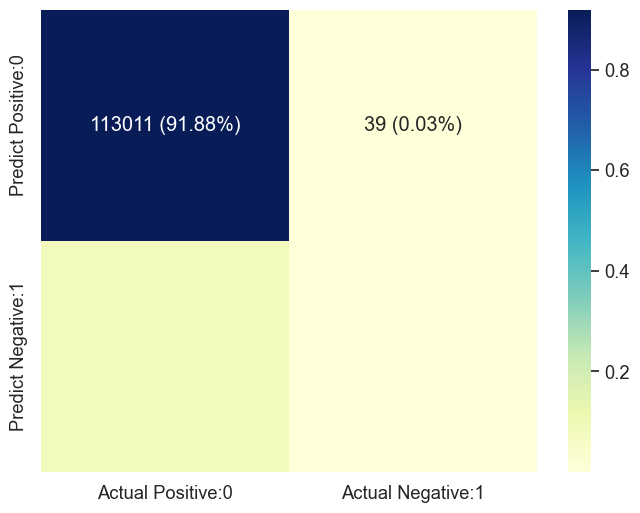

In [63]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [64]:
# Étape 2 : Calculez les scores en utilisant la métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [65]:
for threshold in thresholds:
    y_pred = (y_pred_proba1_test > threshold).astype(int)
    current_score = custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10)
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score -255631
threshold 0.2 score -59335
threshold 0.30000000000000004 score -20482
threshold 0.4 score -12149
threshold 0.5 score -10262
threshold 0.6000000000000001 score -10021
threshold 0.7000000000000001 score -9972
threshold 0.8 score -9953
Meilleur seuil (score personnalisé) : 0.80


XGBOOST

In [66]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [67]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [68]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
 X_test

array([[-1.58064318,  5.91781201, -0.0932696 , ...,  0.65825309,
        -0.32160975, -0.27662835],
       [ 0.52894825,  5.91781201, -0.0932696 , ...,  0.65825309,
         1.9210387 , -0.27662835],
       [ 0.22896202,  5.91781201, -0.0932696 , ..., -0.59334402,
        -0.32160975, -0.27662835],
       ...,
       [ 1.30950946, -0.16898137, -0.0932696 , ..., -0.59334402,
        -0.32160975, -0.27662835],
       [ 0.80528929, -0.16898137, -0.0932696 , ..., -0.59334402,
        -0.32160975, -0.27662835],
       [-0.37680061, -0.16898137, -0.0932696 , ...,  0.65825309,
        -0.32160975, -0.27662835]])

In [71]:
# Créez un modèle XGBoost Classifier
xgb_model = xgb.XGBClassifier()

In [72]:
# Définissez la grille de paramètres à tester
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

In [73]:
# Créez un objet GridSearchCV en spécifiant le modèle, le paramètre de la grille et la métrique à optimiser (par exemple, 'roc_auc')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=custom_scorer, cv=3)

In [74]:
# Entraînez le modèle de recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [75]:
# Afficher les meilleurs hyperparamètres et la meilleure performance
print("Meilleurs hyperparamètres :", grid_search.best_params_)

Meilleurs hyperparamètres : {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}


In [76]:
xgb_model1 = XGBClassifier(
    learning_rate=0.1,  # Taux d'apprentissage
    n_estimators=300,   # Nombre d'arbres (itérations)
    max_depth=5,       # Profondeur maximale de l'arbre
    objective='binary:logistic',  # Problème de classification binaire
    use_label_encoder=False,      # Désactiver l'encodage automatique des étiquettes
)

In [77]:
# Entraînez le modèle sur les données d'entraînement
xgb_model1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [78]:
# Faites des prédictions sur l'ensemble de test
y_pred2 = xgb_model1.predict(X_test)

In [79]:
y_pred_proba2_test = xgb_model1.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [80]:
y_pred_proba2_train = xgb_model1.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [81]:
auc_test = roc_auc_score(y_test, y_pred_proba2_test)
print("auc_test:", auc_test)

auc_test: 0.7688572389300922


In [82]:
auc_train = roc_auc_score(y_train, y_pred_proba2_train)
print("auc_train:", auc_train)

auc_train: 0.8016536674529707


In [83]:
with mlflow.start_run() as run:
    # Création et entraînement du modèle XGBoost
    xgb_model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=300)
    xgb_model.fit(X_train, y_train)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba_test = xgb_model.predict_proba(X_test)[:, 1]
    auc_test2 = roc_auc_score(y_test, y_pred_proba2_test)
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba2_test)
    
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("xgbmodel", "XGBoostClassifier")
    mlflow.log_metric("AUC_test_XGBoostClassifier", auc_test2)
    
    # Enregistrement du modèle XGBoost dans MLflow
    mlflow.xgboost.log_model(xgb_model, "xgboost-model")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_xgb = "ROC_curve_test_xgb.png"
    plt.savefig(roc_fig_xgb)
    mlflow.log_artifact(roc_fig_xgb)
    plt.close()

      # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=xgb_model ,
        artifact_path="sklearn-xgb_model",
        #signature=signature,
        registered_model_name="sk-learn-xgb_model-model",
    )


Registered model 'sk-learn-xgb_model-model' already exists. Creating a new version of this model...
2023/11/22 11:24:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-xgb_model-model, version 2
Created version '2' of model 'sk-learn-xgb_model-model'.


In [84]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred2)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[112971     79]
 [  9809    144]]

True Positives(TP) =  112971

True Negatives(TN) =  144

False Positives(FP) =  79

False Negatives(FN) =  9809


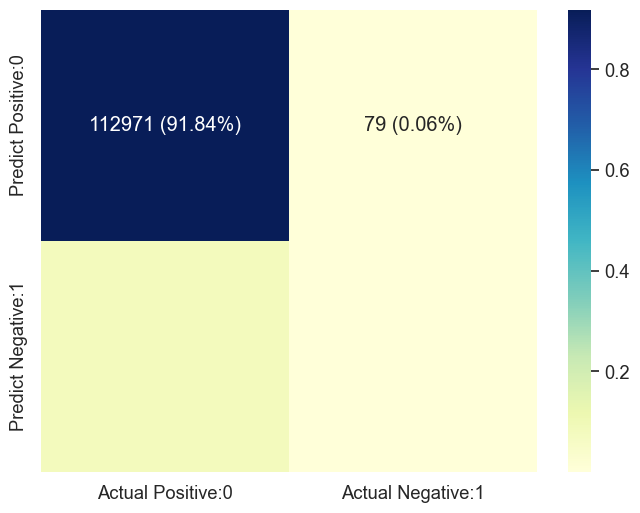

In [85]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred2)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [86]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred2))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    113050
           1       0.65      0.01      0.03      9953

    accuracy                           0.92    123003
   macro avg       0.78      0.51      0.49    123003
weighted avg       0.90      0.92      0.88    123003



In [87]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [88]:
for threshold in thresholds:
    y_pred = (y_pred_proba2_test > threshold).astype(int)
    current_score = custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10)
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score -252840
threshold 0.2 score -65611
threshold 0.30000000000000004 score -24357
threshold 0.4 score -13667
threshold 0.5 score -10599
threshold 0.6000000000000001 score -10038
threshold 0.7000000000000001 score -9952
threshold 0.8 score -9953
Meilleur seuil (score personnalisé) : 0.70


RandomForest

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [90]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [91]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
rf_model = RandomForestClassifier()

In [94]:
# Définir les hyperparamètres à rechercher
hyperparameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]}

In [95]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=hyperparameters, scoring=custom_scorer, cv=3)

In [96]:
# Entraînez le modèle de recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [97]:
# Afficher les meilleurs hyperparamètres et la meilleure performance
print("Meilleurs hyperparamètres :", grid_search.best_params_)

Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 10}


In [98]:
rf1_model = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=10, random_state=42)

In [99]:
rf1_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=10, n_estimators=10,
                       random_state=42)

In [100]:
y_pred_proba3_test = rf1_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [101]:
y_pred_proba3_train = rf1_model.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [102]:
# Faites des prédictions sur l'ensemble de test
y_pred3 = rf1_model.predict(X_test)

In [103]:
auc_test = roc_auc_score(y_test, y_pred_proba3_test)
print("AUC_test:", auc_test)

AUC_test: 0.6807359392328375


In [104]:
auc_train = roc_auc_score(y_train, y_pred_proba3_train)
print("AUC_train:", auc_train)

AUC_train: 0.6850745163660124


In [105]:
with mlflow.start_run() as run:
    # Création et entraînement du modèle Random Forest
    rf_model = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=10, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba3_test = rf_model.predict_proba(X_test)[:, 1]
    auc_test_rf = roc_auc_score(y_test, y_pred_proba3_test)
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba3_test)
    
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test_rf)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("Rfmodel", "RandomForestClassifier")
    mlflow.log_metric("AUC_test_RandomForestClassifier", auc_test_rf)
    
     # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_rf = "ROC_curve_test_rf.png"
    plt.savefig(roc_fig_rf)
    mlflow.log_artifact(roc_fig_rf)
    plt.close()
    
    # Enregistrement du modèle Random Forest dans MLflow
    mlflow.sklearn.log_model(
        sk_model=rf_model,
        artifact_path="random-forest-model",
        registered_model_name="sk-learn-random-forest-model",
    )
 

Registered model 'sk-learn-random-forest-model' already exists. Creating a new version of this model...
2023/11/22 17:44:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-random-forest-model, version 2
Created version '2' of model 'sk-learn-random-forest-model'.


In [106]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred3)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[113050      0]
 [  9953      0]]

True Positives(TP) =  113050

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  9953


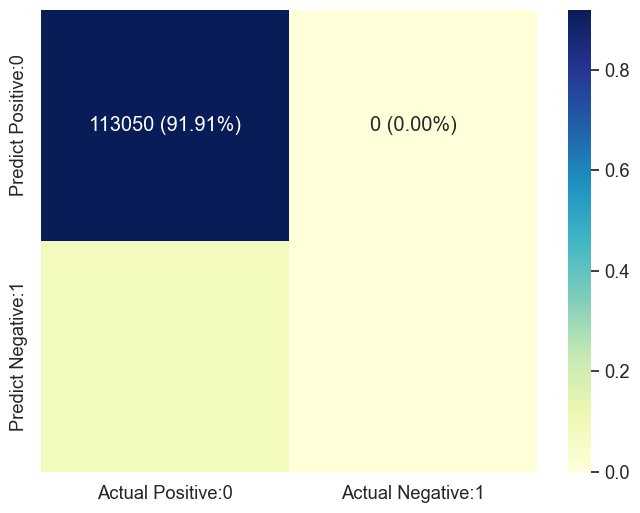

In [107]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred3)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [108]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred3))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    113050
           1       0.00      0.00      0.00      9953

    accuracy                           0.92    123003
   macro avg       0.46      0.50      0.48    123003
weighted avg       0.84      0.92      0.88    123003



In [109]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [110]:
for threshold in thresholds:
    y_pred = (y_pred_proba3_test > threshold).astype(int)
    current_score = custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10)
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score -208117
threshold 0.2 score -9952
threshold 0.30000000000000004 score -9953
threshold 0.4 score -9953
threshold 0.5 score -9953
threshold 0.6000000000000001 score -9953
threshold 0.7000000000000001 score -9953
threshold 0.8 score -9953
Meilleur seuil (score personnalisé) : 0.20


SMOTE

CATBOOST

In [111]:
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool

In [112]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [113]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [114]:
smote = SMOTE(sampling_strategy=0.75)

In [115]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [116]:
# Créer le modèle CatBoost
catboost_model = CatBoostClassifier()

In [117]:
param_grid = {'iterations': [100, 200],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6]
}

In [118]:
grid_search = GridSearchCV(catboost_model, param_grid, cv=5, n_jobs=-1, scoring=custom_scorer)

In [119]:
grid_search.fit(X_train_resampled, y_train_resampled)

0:	learn: 0.6699165	total: 221ms	remaining: 21.9s
1:	learn: 0.6528818	total: 431ms	remaining: 21.1s
2:	learn: 0.6348045	total: 613ms	remaining: 19.8s
3:	learn: 0.6083276	total: 840ms	remaining: 20.2s
4:	learn: 0.5955122	total: 1.06s	remaining: 20.2s
5:	learn: 0.5800540	total: 1.24s	remaining: 19.4s
6:	learn: 0.5712168	total: 1.4s	remaining: 18.6s
7:	learn: 0.5623471	total: 1.57s	remaining: 18.1s
8:	learn: 0.5333525	total: 1.77s	remaining: 17.9s
9:	learn: 0.5267125	total: 2s	remaining: 18s
10:	learn: 0.5175227	total: 2.19s	remaining: 17.7s
11:	learn: 0.5117594	total: 2.41s	remaining: 17.7s
12:	learn: 0.5067604	total: 2.65s	remaining: 17.7s
13:	learn: 0.5019493	total: 2.87s	remaining: 17.6s
14:	learn: 0.4941551	total: 3.06s	remaining: 17.3s
15:	learn: 0.4896153	total: 3.24s	remaining: 17s
16:	learn: 0.4857471	total: 3.42s	remaining: 16.7s
17:	learn: 0.4814369	total: 3.54s	remaining: 16.1s
18:	learn: 0.4775579	total: 3.7s	remaining: 15.8s
19:	learn: 0.4746437	total: 3.89s	remaining: 15.6s

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x17fd9b280>,
             n_jobs=-1,
             param_grid={'depth': [3, 6], 'iterations': [100, 200],
                         'learning_rate': [0.01, 0.1]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

122:	learn: 0.3443946	total: 23s	remaining: 14.4s
123:	learn: 0.3438257	total: 23.3s	remaining: 14.3s
124:	learn: 0.3435907	total: 23.5s	remaining: 14.1s
125:	learn: 0.3433318	total: 23.8s	remaining: 14s
126:	learn: 0.3430014	total: 24.2s	remaining: 13.9s
127:	learn: 0.3427583	total: 24.5s	remaining: 13.8s
128:	learn: 0.3398269	total: 24.7s	remaining: 13.6s
129:	learn: 0.3395557	total: 24.9s	remaining: 13.4s
130:	learn: 0.3392578	total: 25.1s	remaining: 13.2s
131:	learn: 0.3390190	total: 25.3s	remaining: 13s
132:	learn: 0.3387771	total: 25.4s	remaining: 12.8s
133:	learn: 0.3384917	total: 25.6s	remaining: 12.6s
134:	learn: 0.3382152	total: 25.8s	remaining: 12.4s
135:	learn: 0.3380195	total: 26s	remaining: 12.2s
136:	learn: 0.3377674	total: 26.1s	remaining: 12s
137:	learn: 0.3375602	total: 26.3s	remaining: 11.8s
138:	learn: 0.3373383	total: 26.5s	remaining: 11.6s
139:	learn: 0.3370383	total: 26.6s	remaining: 11.4s
140:	learn: 0.3367952	total: 26.8s	remaining: 11.2s
141:	learn: 0.3365409	

In [120]:
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

Meilleurs hyperparamètres : {'depth': 3, 'iterations': 100, 'learning_rate': 0.01}


In [121]:
catboost1_model = CatBoostClassifier(**best_params)

In [122]:
catboost1_model.fit(X_train_resampled, y_train_resampled)

0:	learn: 0.6906111	total: 56.6ms	remaining: 5.6s
1:	learn: 0.6881500	total: 96.9ms	remaining: 4.75s
2:	learn: 0.6857211	total: 136ms	remaining: 4.38s
3:	learn: 0.6833486	total: 181ms	remaining: 4.35s
4:	learn: 0.6810180	total: 219ms	remaining: 4.16s
5:	learn: 0.6787456	total: 256ms	remaining: 4.01s
6:	learn: 0.6765293	total: 299ms	remaining: 3.98s
7:	learn: 0.6743463	total: 345ms	remaining: 3.97s
8:	learn: 0.6722234	total: 392ms	remaining: 3.96s
9:	learn: 0.6701007	total: 432ms	remaining: 3.89s
10:	learn: 0.6682262	total: 472ms	remaining: 3.81s
11:	learn: 0.6662180	total: 514ms	remaining: 3.77s
12:	learn: 0.6640655	total: 556ms	remaining: 3.72s
13:	learn: 0.6621130	total: 597ms	remaining: 3.67s
14:	learn: 0.6603618	total: 635ms	remaining: 3.6s
15:	learn: 0.6584708	total: 673ms	remaining: 3.53s
16:	learn: 0.6564188	total: 709ms	remaining: 3.46s
17:	learn: 0.6545947	total: 752ms	remaining: 3.42s
18:	learn: 0.6527604	total: 792ms	remaining: 3.38s
19:	learn: 0.6507905	total: 830ms	remaini

In [123]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred_grid))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92    113240
           1       0.16      0.20      0.18      9763

    accuracy                           0.86    123003
   macro avg       0.55      0.56      0.55    123003
weighted avg       0.87      0.86      0.86    123003



In [124]:
y_pred_proba1_test = catboost1_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [125]:
y_pred_proba1_train = catboost1_model.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [126]:
y_pred1 = catboost1_model.predict(X_test)

In [127]:
auc_train = roc_auc_score(y_train, y_pred_proba1_train)
print("AUC_train:", auc_train)

AUC_train: 0.6554116418364411


In [128]:
auc_test = roc_auc_score(y_test, y_pred_proba1_test)
print("AUC_test:", auc_test)

AUC_test: 0.6545473939537654


In [129]:
# Enregistrement de l'exécution avec MLflow
with mlflow.start_run() as run:
    # Création et entraînement du modèle CatBoost
    catboost_model_smote = CatBoostClassifier(**best_params)
    catboost_model_smote.fit(X_train_resampled, y_train_resampled)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba4_test = catboost_model_smote.predict_proba(X_test)[:, 1]
    auc_test4 = roc_auc_score(y_test, y_pred_proba4_test)
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba4_test)
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test4)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("model", "CatBoostClassifier_smote")
    mlflow.log_metric("AUC_test_CatBoostClassifier_smote", auc_test)
    
    # Enregistrement du modèle CatBoost dans MLflow
    mlflow.catboost.log_model(catboost_model_smote, "catboost-model-smote")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_cat = "ROC_curve_test1.png"
    plt.savefig(roc_fig_cat)
    mlflow.log_artifact(roc_fig_cat)
    plt.close()
    
    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=catboost_model1 ,
        artifact_path="sklearn-catboostmodel-smote",
        #signature=signature,
        registered_model_name="sk-learn-CatBoostClassifiersmote-model",
    )

0:	learn: 0.6906111	total: 62.6ms	remaining: 6.2s
1:	learn: 0.6881500	total: 102ms	remaining: 4.98s
2:	learn: 0.6857211	total: 139ms	remaining: 4.48s
3:	learn: 0.6833486	total: 177ms	remaining: 4.25s
4:	learn: 0.6810180	total: 213ms	remaining: 4.05s
5:	learn: 0.6787456	total: 251ms	remaining: 3.93s
6:	learn: 0.6765293	total: 294ms	remaining: 3.91s
7:	learn: 0.6743463	total: 339ms	remaining: 3.89s
8:	learn: 0.6722234	total: 380ms	remaining: 3.84s
9:	learn: 0.6701007	total: 421ms	remaining: 3.79s
10:	learn: 0.6682262	total: 463ms	remaining: 3.74s
11:	learn: 0.6662180	total: 503ms	remaining: 3.69s
12:	learn: 0.6640655	total: 547ms	remaining: 3.66s
13:	learn: 0.6621130	total: 586ms	remaining: 3.6s
14:	learn: 0.6603618	total: 623ms	remaining: 3.53s
15:	learn: 0.6584708	total: 661ms	remaining: 3.47s
16:	learn: 0.6564188	total: 697ms	remaining: 3.4s
17:	learn: 0.6545947	total: 738ms	remaining: 3.36s
18:	learn: 0.6527604	total: 777ms	remaining: 3.31s
19:	learn: 0.6507905	total: 815ms	remaining

Successfully registered model 'sk-learn-CatBoostClassifiersmote-model'.
2023/11/21 19:33:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-CatBoostClassifiersmote-model, version 1
Created version '1' of model 'sk-learn-CatBoostClassifiersmote-model'.


In [130]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[103317   9923]
 [  7830   1933]]

True Positives(TP) =  103317

True Negatives(TN) =  1933

False Positives(FP) =  9923

False Negatives(FN) =  7830


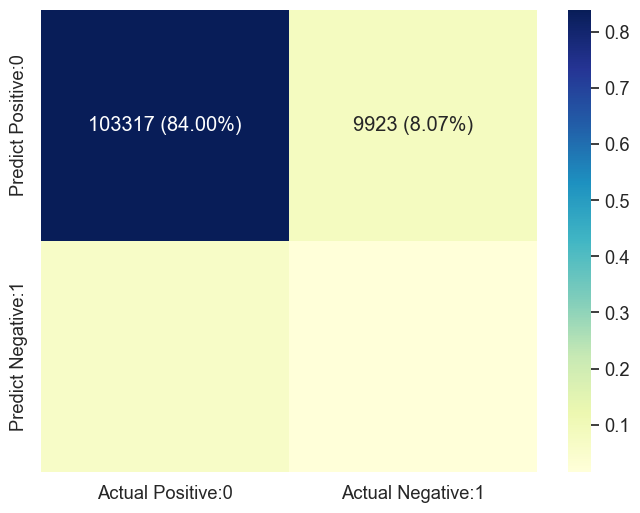

In [131]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred1)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [132]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred1))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92    113240
           1       0.16      0.20      0.18      9763

    accuracy                           0.86    123003
   macro avg       0.55      0.56      0.55    123003
weighted avg       0.87      0.86      0.86    123003



In [133]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [134]:
for threshold in thresholds:
    y_pred = (y_pred_proba1_test  > threshold).astype(int)
    current_score = custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10)
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score -1132400
threshold 0.2 score -1130045
threshold 0.30000000000000004 score -892766
threshold 0.4 score -439328
threshold 0.5 score -107060
threshold 0.6000000000000001 score -31516
threshold 0.7000000000000001 score -10495
threshold 0.8 score -9763
Meilleur seuil (score personnalisé) : 0.80


XGBOOST

In [135]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [136]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [137]:
smote = SMOTE(sampling_strategy=0.75)

In [138]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [139]:
X_test

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
486583,179072,0,0,0,0,0,0,0,0,0,...,247500.0,0.046618,0.120564,29839.5,450000.0,0.088990,0.0,0.0,0.0,0.0
279850,279850,0,0,0,0,0,0,0,1,0,...,157500.0,0.061626,0.113029,17802.0,238500.0,0.681945,3.0,3.0,0.0,0.0
281214,281214,0,0,0,0,0,0,0,0,1,...,101250.0,0.056101,0.135889,27517.5,454500.0,0.693976,0.0,0.0,0.0,0.0
317509,9998,0,0,0,0,0,0,0,0,0,...,180000.0,0.079375,0.076787,27643.5,315000.0,0.286832,0.0,0.0,0.0,0.0
533724,226213,0,0,0,0,0,0,0,0,0,...,85500.0,0.098222,0.093053,15912.0,162000.0,0.157273,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408916,101405,0,0,0,0,0,0,0,0,0,...,67500.0,0.035915,0.077817,21010.5,585000.0,0.569659,0.0,0.0,0.0,0.0
342566,35055,0,0,0,0,0,0,0,0,0,...,90000.0,0.051412,0.102825,18508.5,360000.0,0.602304,0.0,0.0,0.0,0.0
42424,42424,0,0,0,0,0,0,0,0,1,...,58500.0,0.039660,0.294500,34456.5,702000.0,0.178580,1.0,1.0,0.0,0.0
221844,221844,0,0,0,0,0,0,0,0,0,...,45000.0,0.118668,0.177100,15939.0,126000.0,0.094264,0.0,0.0,0.0,0.0


In [140]:
# Créez un modèle XGBoost Classifier
xgb_model = xgb.XGBClassifier()

In [141]:
# Définissez la grille de paramètres à tester
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

In [142]:
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, n_jobs=-1, scoring=custom_scorer)

In [143]:
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [144]:
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

Meilleurs hyperparamètres : {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}


In [145]:
xgb1_model =  xgb.XGBClassifier(**best_params)

In [146]:
xgb1_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [147]:
y_pred_proba2_test = xgb1_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [148]:
y_pred_proba2_train = xgb1_model.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [149]:
y_pred2 = xgb1_model.predict(X_test)

In [150]:
auc_train = roc_auc_score(y_train, y_pred_proba2_train)
print("AUC_train:", auc_train)

AUC_train: 0.6606603875611794


In [151]:
auc_test = roc_auc_score(y_test, y_pred_proba2_test)
print("AUC_test:", auc_test)

AUC_test: 0.6600911520919331


In [156]:
with mlflow.start_run() as run:
    # Création et entraînement du modèle XGBoost
    xgb_model_smote = xgb.XGBClassifier(**best_params)
    xgb_model_smote.fit(X_train_resampled, y_train_resampled)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba5_test = xgb_model_smote.predict_proba(X_test)[:, 1]
    auc_test5 = roc_auc_score(y_test, y_pred_proba5_test)
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba5_test)
    
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("model", "XGBoostClassifier_smote")
    mlflow.log_metric("AUC_test_XGBoostClassifier_smote", auc_test5)
    
    # Enregistrement du modèle XGBoost dans MLflow
    mlflow.xgboost.log_model(xgb_model_smote, "xgboost-model-smote")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_xgb = "ROC_curve_test_xgb.png"
    plt.savefig(roc_fig_xgb)
    mlflow.log_artifact(roc_fig_xgb)
    plt.close()

      # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=xgb_model ,
        artifact_path="sklearn-xgb_model_smote",
        #signature=signature,
        registered_model_name="sk-learn-xgb_model_smote-model",
    )

Successfully registered model 'sk-learn-xgb_model_smote-model'.
2023/11/21 19:56:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-xgb_model_smote-model, version 1
Created version '1' of model 'sk-learn-xgb_model_smote-model'.


In [157]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred2)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[104735   8505]
 [  8036   1727]]

True Positives(TP) =  104735

True Negatives(TN) =  1727

False Positives(FP) =  8505

False Negatives(FN) =  8036


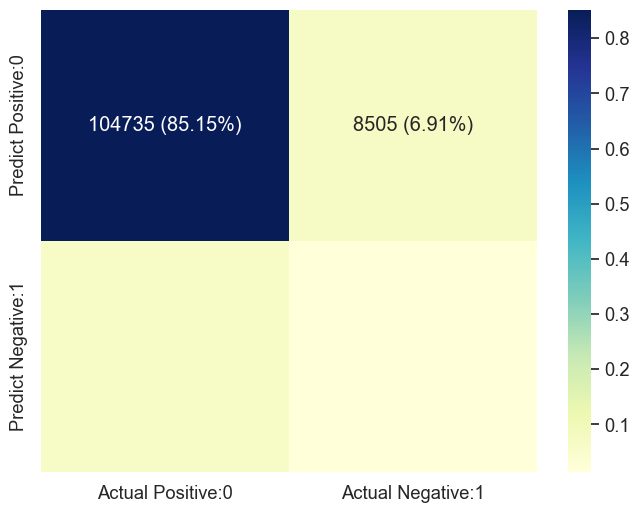

In [158]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred2)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [159]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred2))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93    113240
           1       0.17      0.18      0.17      9763

    accuracy                           0.87    123003
   macro avg       0.55      0.55      0.55    123003
weighted avg       0.87      0.87      0.87    123003



In [160]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [161]:
for threshold in thresholds:
    y_pred = (y_pred_proba2_test  > threshold).astype(int)
    current_score = custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10)
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score -1132400
threshold 0.2 score -1126985
threshold 0.30000000000000004 score -734434
threshold 0.4 score -314738
threshold 0.5 score -93086
threshold 0.6000000000000001 score -15173
threshold 0.7000000000000001 score -9793
threshold 0.8 score -9763
Meilleur seuil (score personnalisé) : 0.80


RANDOMFOREST

In [162]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [163]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [164]:
smote = SMOTE(sampling_strategy=0.75)

In [165]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [166]:
# Créez un modèle RandomForest Classifier
rf_model = RandomForestClassifier()

In [167]:
hyperparameters = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 5, 10]}

In [168]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=hyperparameters, scoring=custom_scorer, cv=3)

In [169]:
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring=make_scorer(custom_score, greater_is_better=False, false_positive_cost=1, false_negative_cost=10))

In [170]:
best_params = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params)

Meilleurs hyperparamètres : {'max_depth': 5, 'n_estimators': 10}


In [171]:
rf1_model =  RandomForestClassifier(**best_params)

In [172]:
rf1_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=5, n_estimators=10)

In [173]:
y_pred_proba3_test = rf1_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [174]:
y_pred_proba3_train = rf1_model.predict_proba(X_train)[:, 1]  # Probabilité de la classe positive

In [175]:
y_pred3 = rf1_model.predict(X_test)

In [176]:
auc_train = roc_auc_score(y_train, y_pred_proba3_train)
print("AUC_train:", auc_train)

AUC_train: 0.6268929262284089


In [177]:
auc_test = roc_auc_score(y_test, y_pred_proba3_test)
print("AUC_test:", auc_test)

AUC_test: 0.6263322905817359


In [178]:
# Enregistrement de l'exécution avec MLflow
with mlflow.start_run() as run:
    # Création et entraînement du modèle CatBoost
    rf_model_smote = RandomForestClassifier(**best_params)
    rf_model_smote.fit(X_train_resampled, y_train_resampled)
    
    # Prédiction et calcul de l'AUC sur les données de test
    y_pred_proba5_test = rf_model_smote.predict_proba(X_test)[:, 1]
    auc_test5 = roc_auc_score(y_test, y_pred_proba5_test)
    
    # Calcul de la courbe ROC pour les données de test
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba5_test)
    # Enregistrement de la courbe ROC dans MLflow
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_test5)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_param("model", " rf_model_smote")
    mlflow.log_metric("AUC_test_ rf_model_smote", auc_test5)
    
    # Enregistrement du modèle CatBoost dans MLflow
    mlflow.catboost.log_model(catboost_model_smote, "rf_model_smote")
    
    # Enregistrement de la courbe ROC en tant qu'artefact
    roc_fig_cat = "ROC_curve_test1.png"
    plt.savefig(roc_fig_cat)
    mlflow.log_artifact(roc_fig_cat)
    plt.close()
    
    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=catboost_model1 ,
        artifact_path="sklearn-rfmodel-smote",
        #signature=signature,
        registered_model_name="sk-learn-rfClassifiersmote-model",
    )

Successfully registered model 'sk-learn-rfClassifiersmote-model'.
2023/11/21 22:04:06 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: sk-learn-rfClassifiersmote-model, version 1
Created version '1' of model 'sk-learn-rfClassifiersmote-model'.


In [179]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred3)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[102359  10881]
 [  7836   1927]]

True Positives(TP) =  102359

True Negatives(TN) =  1927

False Positives(FP) =  10881

False Negatives(FN) =  7836


In [180]:
grid_search_model = grid_search.best_estimator_
y_pred_grid = grid_search_model.predict(X_test)
 
# Print classification report for the Grid Search model
print("Grid Search - Classification Report:")
print(classification_report(y_test, y_pred3))

Grid Search - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92    113240
           1       0.15      0.20      0.17      9763

    accuracy                           0.85    123003
   macro avg       0.54      0.55      0.54    123003
weighted avg       0.87      0.85      0.86    123003



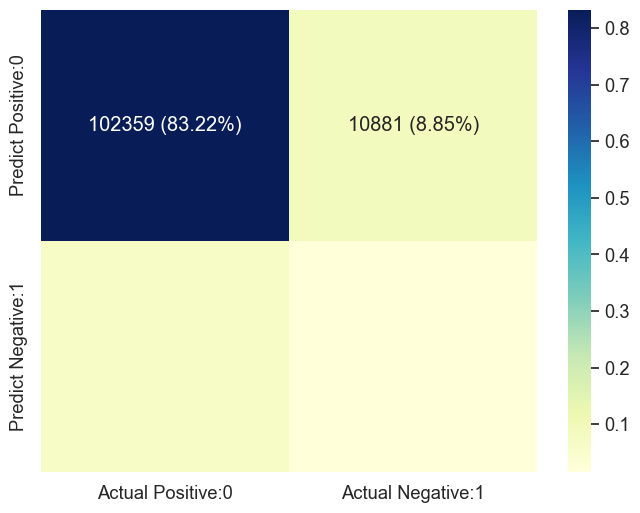

In [181]:
# Suppose cm is your confusion matrix
cm = confusion_matrix(y_test, y_pred3)

# Calculate the total number of samples
total_samples = cm.sum()

# Calculate percentages
cm_percentage = cm.astype('float') / total_samples  # Normalize by dividing by the total number of samples

# Create a DataFrame from the percentage matrix
cm_percentage_df = pd.DataFrame(data=cm_percentage, columns=['Actual Positive:0', 'Actual Negative:1'],
                                index=['Predict Positive:0', 'Predict Negative:1'])

# Create an empty DataFrame to store both number and percentage annotations
annotations = pd.DataFrame(columns=['Actual Positive:0', 'Actual Negative:1'],
                            index=['Predict Positive:0', 'Predict Negative:1'])

# Loop through the confusion matrix and add both number and percentage annotations
for i in range(2):
    for j in range(2):
        annotations.iloc[i, j] = f"{cm[i, j]} ({cm_percentage_df.iloc[i, j]*100:.2f}%)"

# Set up the figure
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size

# Create the heatmap with annotations
sns.heatmap(cm_percentage_df, annot=annotations, fmt="", cmap='YlGnBu')

plt.show()
#Ce code prend en compte le nombre total d'individus dans la variable total_samples et calcule le pourcentage en divisant par ce nombre total. Les annotations comprennent à la fois le nombre et le pourcentage. Le format d'affichage des pourcentages peut également être ajusté selon vos préférences.


In [182]:
# Étape 2 : Calculez les scores en utilisant votre métrique personnalisée
thresholds = np.arange(0.1, 0.9, 0.1)  # Vous pouvez ajuster l'intervalle
best_score = float('-inf')  # Initialisez le meilleur score à négatif infini
best_threshold = 0

In [183]:
for threshold in thresholds:
    y_pred = (y_pred_proba3_test  > threshold).astype(int)
    current_score = custom_score(y_test, y_pred, false_positive_cost=1, false_negative_cost=10)
    print(f"threshold {threshold} score {current_score}")

    if current_score > best_score:
        best_score = current_score
        best_threshold = threshold

# Étape 3 : Sélectionnez le seuil optimal
print("Meilleur seuil (score personnalisé) : {:.2f}".format(best_threshold))

threshold 0.1 score -1132350
threshold 0.2 score -1041495
threshold 0.30000000000000004 score -725752
threshold 0.4 score -366828
threshold 0.5 score -116646
threshold 0.6000000000000001 score -21210
threshold 0.7000000000000001 score -9820
threshold 0.8 score -9763
Meilleur seuil (score personnalisé) : 0.80


FEATURE IMPORTANCE

Text(0.5, 1.0, 'Feature Importance globale')

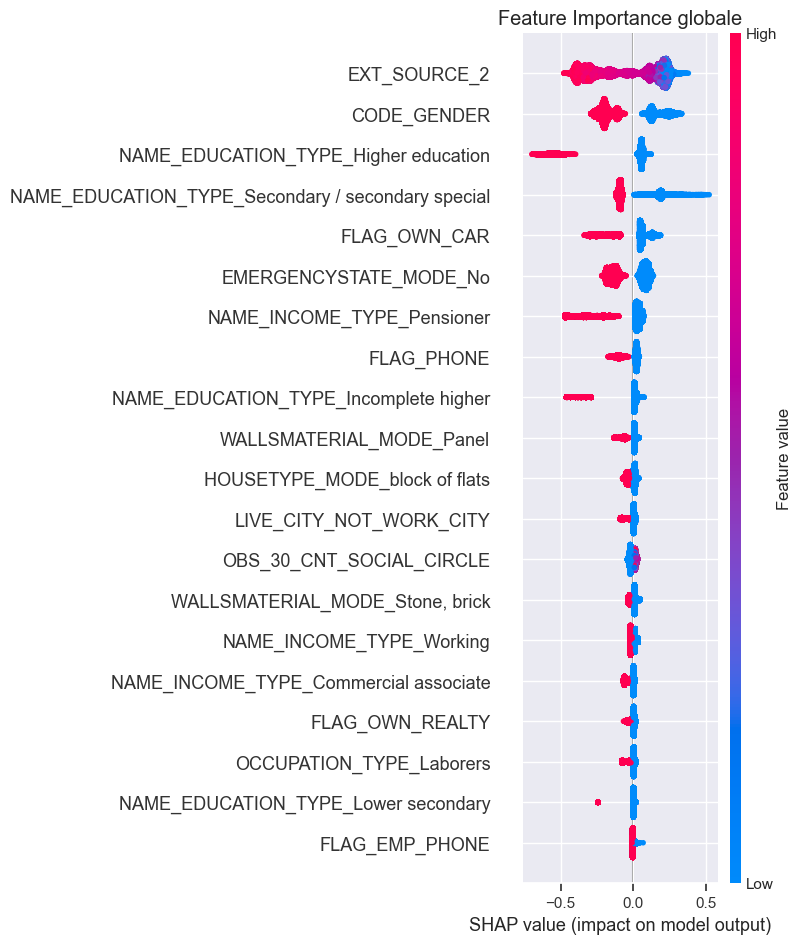

In [184]:
explainer = shap.TreeExplainer(xgb1_model)
shap_values = explainer.shap_values(X_test)

# Afficher les summary plots des SHAP values
shap.summary_plot(shap_values, X_test, show=False)
plt.title('Feature Importance globale')

Avec 1000 échantillons

In [185]:
X = df_filled.drop('TARGET', axis=1)
y = df_filled['TARGET']

In [186]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [187]:
df_smote = pd.DataFrame(X_smote, columns=X.columns)
df_smote['TARGET'] = y_smote

In [188]:
df_select = df_smote.head(1000)

In [189]:
X = df_select.drop('TARGET', axis=1)
y = df_select['TARGET']

In [190]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [191]:
xgb_model = XGBClassifier(
    learning_rate=0.01,  # Taux d'apprentissage
    n_estimators=100,   # Nombre d'arbres (itérations)
    max_depth=4,       # Profondeur maximale de l'arbre
    objective='binary:logistic',  # Problème de classification binaire
    use_label_encoder=False,      # Désactiver l'encodage automatique des étiquettes
)

In [192]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [193]:
X_train

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
29,29,0,0,0,0,0,0,0,0,0,...,90000.0,0.050000,0.100000,9000.0,180000.0,0.502779,0.0,0.0,0.0,0.0
535,535,0,0,0,0,0,0,0,0,0,...,99000.0,0.037416,0.137909,13653.0,315000.0,0.579265,0.0,0.0,0.0,0.0
695,695,0,0,0,0,0,0,0,0,0,...,39375.0,0.079321,0.205343,32341.5,333000.0,0.132357,1.0,1.0,0.0,0.0
557,557,0,0,0,0,0,0,0,0,1,...,90000.0,0.039298,0.329750,29677.5,675000.0,0.587131,0.0,0.0,0.0,0.0
836,836,0,0,0,0,0,0,0,0,0,...,78750.0,0.056056,0.209143,32940.0,544500.0,0.570907,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,106,0,0,0,0,0,0,0,0,1,...,63000.0,0.099391,0.208000,26208.0,238500.0,0.571331,0.0,0.0,0.0,0.0
270,270,0,0,0,0,0,0,0,0,0,...,43875.0,0.029346,0.403641,35419.5,945000.0,0.707841,0.0,0.0,0.0,0.0
860,860,0,0,0,0,0,0,0,0,1,...,75000.0,0.039740,0.278100,62572.5,1350000.0,0.439206,0.0,0.0,0.0,0.0
435,435,0,0,0,0,0,0,0,0,0,...,101250.0,0.085814,0.205800,41674.5,450000.0,0.750615,0.0,0.0,0.0,0.0


In [194]:
y_pred_class = xgb_model.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive

In [195]:
y_pred_classes = xgb_model.predict_proba(X)[:, 1] 

In [196]:
df_select['score'] = y_pred_classes

In [197]:
df_select.head(100)

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TARGET,score
0,0,0,0,0,0,0,0,0,0,0,...,0.121978,24700.5,351000.0,0.262949,2.0,2.0,2.0,2.0,1,0.303106
1,1,0,0,0,0,0,0,0,0,1,...,0.132217,35698.5,1129500.0,0.622246,1.0,1.0,0.0,0.0,0,0.078365
2,2,0,0,0,0,0,0,0,0,1,...,0.100000,6750.0,135000.0,0.555912,0.0,0.0,0.0,0.0,0,0.075252
3,3,0,0,0,0,0,0,0,0,0,...,0.219900,29686.5,297000.0,0.650442,2.0,2.0,0.0,0.0,0,0.072133
4,4,0,0,0,0,0,0,0,0,0,...,0.179963,21865.5,513000.0,0.322738,0.0,0.0,0.0,0.0,0,0.096763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0,0,0,0,0,0,0,0,1,...,0.087529,6696.0,135000.0,0.593019,0.0,0.0,0.0,0.0,0,0.087189
96,96,0,0,0,0,0,0,0,0,1,...,0.167400,22599.0,225000.0,0.154937,0.0,0.0,0.0,0.0,0,0.129994
97,97,0,0,0,0,0,0,0,0,0,...,0.163150,14683.5,315000.0,0.334300,0.0,0.0,0.0,0.0,0,0.095412
98,98,0,0,0,0,0,0,0,0,0,...,0.131759,32017.5,900000.0,0.700274,2.0,2.0,0.0,0.0,0,0.073064


In [198]:
auc_test = roc_auc_score(y_test, y_pred_class)
print("AUC_test:", auc_test)

AUC_test: 0.692154255319149


In [199]:
X.to_csv('df_select.csv', index=False)

In [215]:
df_select.to_csv('data_evidently.csv', index=False)

In [201]:
X.to_json('df_select.json', orient='records', lines=True)

In [202]:
len(X.columns)

193

In [203]:
X

,index,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,...,INCOME_PER_PERSON,PAYMENT_RATE,ANNUITY_INCOME_PERC,AMT_ANNUITY,AMT_GOODS_PRICE,EXT_SOURCE_2,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
0,0,0,0,0,0,0,0,0,0,0,...,202500.0,0.060749,0.121978,24700.5,351000.0,0.262949,2.0,2.0,2.0,2.0
1,1,0,0,0,0,0,0,0,0,1,...,135000.0,0.027598,0.132217,35698.5,1129500.0,0.622246,1.0,1.0,0.0,0.0
2,2,0,0,0,0,0,0,0,0,1,...,67500.0,0.050000,0.100000,6750.0,135000.0,0.555912,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,67500.0,0.094941,0.219900,29686.5,297000.0,0.650442,2.0,2.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,121500.0,0.042623,0.179963,21865.5,513000.0,0.322738,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,0,0,0,0,0,0,0,1,0,...,112500.0,0.036183,0.159520,17946.0,409500.0,0.610743,4.0,4.0,0.0,0.0
996,996,0,0,0,0,0,0,0,0,0,...,225000.0,0.051176,0.253340,57001.5,900000.0,0.451694,0.0,0.0,0.0,0.0
997,997,0,0,0,0,0,0,0,1,0,...,72000.0,0.054501,0.195875,28206.0,432000.0,0.675446,0.0,0.0,0.0,0.0
998,998,0,0,0,0,0,0,0,0,1,...,157500.0,0.029340,0.120000,37800.0,1125000.0,0.551400,0.0,0.0,0.0,0.0


In [204]:
if df_select.columns.isin(['customerID']).any():
    print("La colonne customerID se trouve dans le dataframe.")
else:
    print("La colonne customerID ne se trouve pas dans le dataframe.")

La colonne customerID ne se trouve pas dans le dataframe.


In [205]:
import joblib
import streamlit as st

In [206]:
#Sauvegarde du modèle
pickle.dump(xgb_model, open("./xgb_model.pkl", "wb"))

In [207]:
shap.initjs()

In [208]:
X_numpy = np.array(X)

In [209]:
explainer = shap.Explainer(xgb_model, X_numpy)

In [210]:
shap_values = explainer.shap_values(X_numpy)

In [211]:
#Supposons que 'i' est l'index de la ligne que vous souhaitez visualiser
i = 277  # Vous pouvez utiliser n'importe quel autre index

#Récupérez la valeur de l'index à partir de votre DataFrame
selected_index = df_select.loc[i, 'index']

# Utilisez cette valeur pour accéder aux bonnes lignes dans shap_values et X
shap.force_plot(explainer.expected_value, shap_values[selected_index], features=X.iloc[selected_index], feature_names=X.columns)

<Figure size 640x480 with 0 Axes>

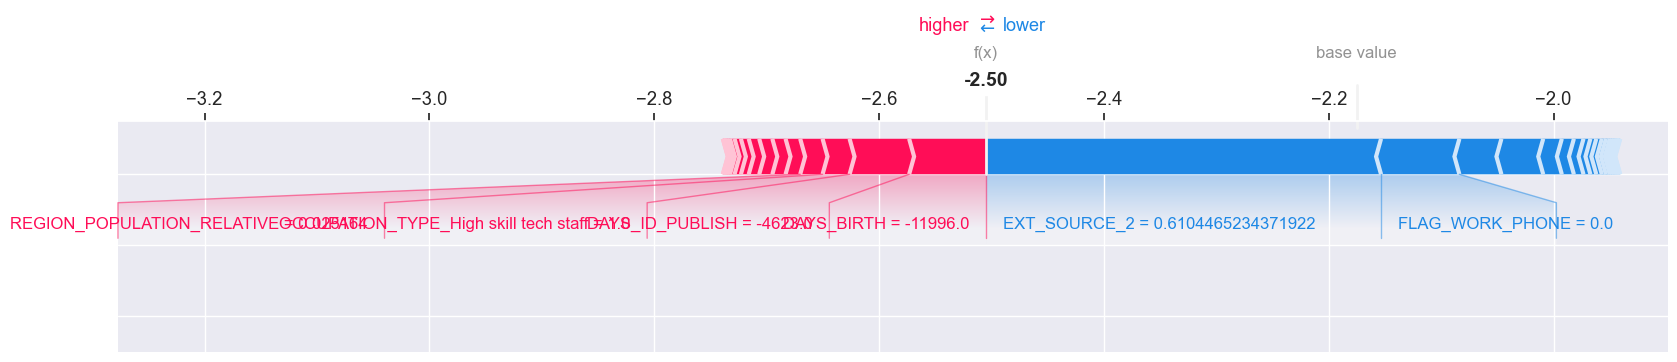

In [212]:
def feature_importance(xgb_model, X_numpy):

    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_numpy)
    shap.initjs()

    return shap.force_plot(explainer.expected_value, shap_values[selected_index], features=X.iloc[selected_index], feature_names=X.columns, matplotlib=True,show=False)


plt.clf()
#data_for_prediction = X_numpy.iloc[2,:].astype(float)
feature_importance(xgb_model, X_numpy)
plt.savefig("gg.png",dpi=150, bbox_inches='tight')

In [213]:
# Loading model to compare the results
model = pickle.load(open('/Users/soneitaraherimalala/Desktop/P7/xgb_model.pkl','rb'))


In [214]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1]:
pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [74]:
pip install streamlit-shap

Note: you may need to restart the kernel to use updated packages.


In [75]:
from streamlit_shap import st_shap

P7.py

In [ ]:
import pandas as pd
import streamlit as st
import requests
import joblib
import shap
import numpy as np
import xgboost
from xgboost import XGBClassifier, plot_importance
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import plotly.express as px
# Définir l'URL de votre API Flask
api_url = 'http://127.0.0.1:5000/predict_score'
#Chargez votre modèle XGBoost
model = pickle.load(open('/Users/soneitaraherimalala/Desktop/P7/xgb_model.pkl', 'rb'))
def main():
    st.title('Dashboard')
    
    # Charger le DataFrame contenant les informations des clients
    df_select = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/df_select.csv')
    #st.subheader(df_filled)

    # Demandez à l'utilisateur de taper le numéro du client
    selected_client_id = st.text_input("Tapez le numéro du client", value="")

    # Afficher le numéro du client et la décision de crédit s'il existe

    if selected_client_id:

        selected_client_id = int(selected_client_id)
        if selected_client_id in df_select['index'].values:
            # Récupérez les informations du client en fonction du numéro du client
            client_info = df_select[df_select['index'] == selected_client_id].iloc[0]

            # Affichez les détails du client
            st.subheader("Détails du client")
            st.write(f"N° Client : {selected_client_id}")

            # Envoyez une requête à l'API pour obtenir le score du client
            api_data = {'data': selected_client_id}  # Utilisez la même clé que dans votre code Flask
            response = requests.post(api_url, json=api_data)
            # Vérifiez si la requête a réussi avant de traiter les résultats
            if response.status_code == 200:
                st.write(response.text)
    
            # Obtenez le score prédit
            prediction = response.json()

            # Accédez à la liste des prédictions sous la clé 'prediction'
            prediction_list = prediction.get('prediction', [])

            # Obtenez le premier élément de la liste, ou None s'il est vide
            predicted_score = prediction_list[0] if prediction_list else None

            # Tentez de convertir la valeur du score en float
            try:
                predicted_score = float(predicted_score)
            except (TypeError, ValueError):
                    pass  # Laissez la valeur inchangée si la conversion échoue

            # Vérifiez si la valeur du score n'est pas None et est de type numérique
            if predicted_score is not None and isinstance(predicted_score, (int, float)):
                #Classez le client en fonction du score
                if predicted_score < 0.1:
                    st.write("Classe : 0 (Crédit accordé)")
                else:
                    st.write("Classe : 1 (Crédit refusé)")
                    
            if predicted_score is not None and isinstance(predicted_score, (int, float)):
                if predicted_score < 0.1:
                    df_select['Classe'] = 0
                else:
                    df_select['Classe'] = 1
                #st.write(f"Score : {predicted_score}")
                #st.write("Classe :", df_select['Classe'].values[0])
                
            st.write(f"Score : {predicted_score}")
         
           # Seuil
            seuil = 0.8

            # Couleur de la barre de progression (vert si le score est inférieur au seuil, rouge sinon)
            if predicted_score < seuil:
                couleur = 'green'
            else:
                couleur = 'red'

    # Créez la barre de progression
            st.subheader("Barre de progression du score")
            st.progress(predicted_score)

        # Ajoutez une indication du seuil
            st.write(f"Seuil : {seuil}")
            # Calcul de l'importance locale avec SHAP
            st.title("Feature Importance locale")
            st.image('/Users/soneitaraherimalala/gg.png', caption=None, width=None, use_column_width=None, clamp=False, channels='RGB', output_format='auto')
            # Calcul de l'importance locale avec SHAP
            #explainer = shap.Explainer(model)  # Remplacez 'model' par votre modèle
            #shap_values = explainer.shap_values(client_info)  # Expliquez l'importance pour ce client
            st.subheader("Importance locale des features")
            X_numpy = df_select.to_numpy()
            explainer = shap.Explainer(model, X_numpy)
            # Remplacez 'model' par votre modèle XGBoost
            # Calculez les valeurs SHAP pour le client sélectionné
            shap_values = explainer.shap_values(X_numpy[selected_client_id].reshape(1, -1))

            # Affichez le graphique d'importance locale des fonctionnalités pour le client sélectionné
            st.subheader("Importance locale des fonctionnalités")
            shap.initjs()  # Assurez-vous d'appeler cette fonction pour activer JavaScript pour les graphiques SHAP
            
            shap.force_plot(explainer.expected_value, shap_values, df_select.iloc[selected_client_id], feature_names=df_select.columns)
            st.title("Visualisation des fonctionnalités")

            # Sélectionnez la fonctionnalité dans une liste déroulante
            feature1 = st.selectbox("Sélectionnez une fonctionnalité :", df_select.columns[:-1], key="feature1")
           
            # Affichez la distribution de la fonctionnalité selon les classes (barplot)
            st.subheader(f"Distribution de {feature1} selon les classes")
           

            # Créez une figure et un axe
            fig, ax = plt.subplots(figsize=(8, 6))

            # Utilisez sns.histplot pour créer le graphique de distribution
            sns.histplot(data=df_select, x=feature1, hue=df_select['Classe'], multiple="stack", kde=True, ax=ax)

            # Affichez le graphique dans Streamlit en utilisant st.pyplot(fig)
            st.pyplot(fig)


            # Affichez le positionnement de la valeur du client sur la fonctionnalité sélectionnée (scatterplot)
            st.subheader(f"Positionnement de la valeur du client sur {feature1}")
            # Ajoutez ici le code pour afficher le scatterplot

    # Affichez les informations sur la valeur sélectionnée
            # Affichez les informations sur la valeur sélectionnée
            selected_value1 = st.slider(
                f"Sélectionnez la valeur de {feature1}",
                float(df_select[feature1].min()),
                float(df_select[feature1].max()),
                float(df_select[feature1].mean()), key="feature1_slider"
                )
            st.write(f"Vous avez sélectionné la valeur {selected_value1} pour {feature1}")
            # Affichez la distribution de la première fonctionnalité selon les classes (barplot)
            
            # Sélectionnez la deuxième fonctionnalité dans une liste déroulante
            feature2 = st.selectbox("Sélectionnez une fonctionnalité :", df_select.columns[:-1], key="feature2")
            st.subheader(f"Distribution de {feature2} selon les classes")

            
            # Utilisez plt.figure() pour créer la figure au lieu de plt.subplots()
            fig2 = plt.figure(figsize=(8, 6))

            # Utilisez sns.histplot pour créer le graphique de distribution
            sns.histplot(data=df_select, x=feature2, hue='Classe', multiple="stack", kde=True)

            # Affichez le graphique dans Streamlit
            st.pyplot(fig2)
            
            st.subheader(f"Positionnement de la valeur du client sur {feature2}")
            selected_value2 = st.slider(
                f"Sélectionnez la valeur de {feature2}",
                float(df_select[feature2].min()),
                float(df_select[feature2].max()),
                float(df_select[feature2].mean()), key="feature2_slider"
                )
                    
            st.write(f"Vous avez sélectionné la valeur {selected_value2} pour {feature2}")
            # Affichez un graphique de dispersion (scatter plot) entre feature1 et feature2
            st.subheader(f"Analyse bivariée entre {feature1} et {feature2}")
            #df_select['score'] = prediction_list # R
            df_select['scores'] = model.predict(df_select[df_select.columns[:-1]])
            # Utilisez plt.figure() pour créer la figure
            fig3 = plt.figure(figsize=(8, 6))

           
            # Utilisez sns.scatterplot pour créer le graphique de dispersion avec une palette de couleurs
            sns.scatterplot(data=df_select, x=feature1, y=feature2, hue='scores', palette='coolwarm', legend='full')

            # Affichez le graphique dans Streamlit
            st.pyplot(fig3)
           
            
            
# Mettez à jour le scatterplot avec la ligne correspondant à la valeur sélectionnée
# Ajoutez ici le code pour mettre à jour le scatterplot en fonction de la valeur sélectionnée
        else:
            st.write("Le numéro du client n'existe pas dans le DataFrame.")
     
if __name__ == '__main__':
    main()

Score.py

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
from flask import Flask, request, jsonify
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pickle
import requests
import json
  
#app = Flask(__name__)
#model = pickle.load(open('/Users/soneitaraherimalala/xgb1_model.pkl', 'rb'))

#@app.route('/predict', methods=['POST'])
#def predict_credit_score():
    #data = request.get_json(force=True)
    #print(data)
    #prediction = model.predict_proba([[np.array(data['data'])]])
    #prediction = model.predict_proba([[np.array(data['data'])]])
    #output = prediction[0]
    #return jsonify(output)

#if __name__ == "__main__":
    #app.run(debug=True)
    
from flask import Flask, request, jsonify
import pickle
import pandas as pd
import numpy as np

app = Flask(__name__)

#Chargez votre modèle XGBoost
model = pickle.load(open('/Users/soneitaraherimalala/Desktop/P7/xgb_model.pkl', 'rb'))

# Chargez votre dataframe
df_select = pd.read_csv('/Users/soneitaraherimalala/Desktop/P7/df_select.csv')


@app.route('/predict_score', methods=['POST'])
def predict_score():
    print('test1')
    try:
        # Récupérez les données d'entrée au format JSON depuis la requête
        data = request.get_json(force=True)
        print(data)
       #Assurez-vous que les données reçues correspondent aux caractéristiques attendues par le modèle
        input_data = data.get('data')
        
       
        print(input_data)
        if input_data is None:
           return jsonify({'error': 'Missing data field'})

        # Transformez les données JSON en un DataFrame
        client = df_select.loc[[input_data]]
        # Assurez-vous que les colonnes du DataFrame sont dans le même ordre que celles du modèle
        #client = df_select.loc[[input_data], columns=df_select.columns]

        print(client.shape)
       
        print(client.shape)
        # Assurez-vous que le DataFrame a les mêmes caractéristiques que celui sur lequel le modèle a été formé
        # Vous devrez peut-être effectuer un prétraitement sur les données en entrée pour les adapter au modèle si nécessaire.
        
        
        y_pred_classes = model.predict_proba(client)[:, 1]  # Obtenez la probabilité de la classe positive

       # Convertissez le tableau NumPy en une liste Python avant de le renvoyer dans la réponse JSON
        y_pred_classes_list = y_pred_classes.tolist()
        # Retournez les scores prédits sous forme de liste
        return jsonify({'prediction': y_pred_classes_list})
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == "__main__":
    app.run(debug=True)



In [ ]:
import unittest
from unittest.mock import patch
from io import StringIO
import sys
import os
import streamlit as st
import unittest
from unittest.mock import patch
from io import StringIO
import P7_script  # Importez le module P7_script correctement

class TestMyCode(unittest.TestCase):
    @patch('builtins.input', side_effect=["123"])
    def test_selected_client(self, mock_input):
        with patch('sys.stdout', new_callable=StringIO) as mock_stdout:
            P7_script.main()  # Assurez-vous que vous appelez la fonction appropriée de P7_script

        output = mock_stdout.getvalue()
        self.assertTrue("Score")  

    def test_nonexistent_client(self):
        with patch('sys.stdout', new_callable=StringIO) as mock_stdout:
            P7_script.main()  # Appelez la fonction appropriée de P7_script
       
        output = mock_stdout.getvalue()
        self.assertTrue("Le numéro du client n'existe pas dans le DataFrame." in output)

if __name__ == '__main__':
    unittest.main()
